## Website 
https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction
## Source 
Luis Candanedo, luismiguel.candanedoibarra '@' umons.ac.be, University of Mons (UMONS). 

## Data Set Information:

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters). 

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from sklearn import (linear_model,pipeline,model_selection,preprocessing,
                    tree,ensemble,svm,decomposition,multioutput,metrics,
                    feature_selection)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme(palette='Dark2',font_scale=1.5)

In [3]:
energy = pd.read_csv('energydata_complete.csv')
# info
print("\ninfo \n",energy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [4]:
# Need to convert time stamp (date) to number of seconds to midnight and store it in dataframe
def timeConvert(ds):
    import datetime
    date_time = datetime.datetime.strptime(ds, "%H:%M:%S")
    a_timedelta = date_time - datetime.datetime(1900, 1, 1)
    seconds = a_timedelta.total_seconds()
    return seconds

time = [t.split(None,1)[1] for t in energy['date']]
24*timeConvert("1:00:00")
timeConvert("23:00:00")
NSM = [timeConvert(t) for t in time]
energy['NSM'] = NSM

In [5]:
# extrain features and outputs. Store them in X and y
X = energy.drop(columns=['date','Appliances'])
y = energy['Appliances']
print(X.keys())
print(y.keys())
# feature selection
# not sure if this should be combined with pipeline. need to check
rfe_selector = feature_selection.RFE(estimator=linear_model.Ridge(),n_features_to_select=None)
rfe_selector.fit(X, y)
rfe_support = rfe_selector.get_support()
X = X.loc[:,rfe_support]
print("Selected features = ",X.columns.tolist())

Index(['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5',
       'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out',
       'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1',
       'rv2', 'NSM'],
      dtype='object')
RangeIndex(start=0, stop=19735, step=1)
Selected features =  ['lights', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'T6', 'RH_7', 'T8', 'RH_8', 'T9', 'T_out', 'Windspeed']


In [6]:
# split test set
Xtrain, Xtest, ytrain,ytest = model_selection.train_test_split(X,y)
# parameters to pass to gridsearchcv
parameters = {'rdg__alpha':[0.1,0.5,1,5,10],
              'pf__degree':range(1,4)}
# build pipeline with feature scaling and Ridge linear regression
pipe = pipeline.Pipeline([
                          ('std',preprocessing.StandardScaler()),
                          ('pf',preprocessing.PolynomialFeatures()),
                          ('rdg',linear_model.Ridge())
])
model = model_selection.GridSearchCV(pipe,
                                     parameters,
                                     refit=True,
                                     n_jobs=-1)
model.fit(Xtrain,ytrain)
# prediction training set and test set 
ptrain = model.predict(Xtrain)
ptest = model.predict(Xtest)

err_train = metrics.mean_squared_error(ytrain,ptrain)
print("-> RMSE of training set = %g with score = %g"%(err_train**0.5,model.score(Xtrain,ytrain)))

err_test = metrics.mean_squared_error(ytest,ptest)
print("-> RMSE = %g of test set with score = %g"%(err_test**0.5,model.score(Xtest,ytest)))

print('best parameters from cross validsation: ',model.best_params_)
print('best score from cross validation: ',model.best_score_)

-> RMSE of training set = 79.7684 with score = 0.399519
-> RMSE = 84.901 of test set with score = 0.297023
best parameters from cross validsation:  {'pf__degree': 3, 'rdg__alpha': 5}
best score from cross validation:  0.3123499208185635


In [7]:
# split test set
Xtrain, Xtest, ytrain,ytest = model_selection.train_test_split(X,y)
# parameters to pass to gridsearchcv
parameters = {'gbm__max_depth':[5],
              'gbm__n_estimators':[100,500,1000,1500,2000]}
# build pipeline with feature scaling and Ridge linear regression
pipe = pipeline.Pipeline([
                          ('std',preprocessing.StandardScaler()),
                          ('gbm',ensemble.GradientBoostingRegressor())
])
model = model_selection.GridSearchCV(pipe,
                                     parameters,
                                     refit=True,
                                     return_train_score=True,
                                     n_jobs=-1)
model.fit(Xtrain,ytrain)
# prediction training set and test set 
ptrain = model.predict(Xtrain)
ptest = model.predict(Xtest)

err_train = metrics.mean_squared_error(ytrain,ptrain)
print("-> RMSE of training set = %g with score = %g"%(err_train**0.5,model.score(Xtrain,ytrain)))

err_test = metrics.mean_squared_error(ytest,ptest)
print("-> RMSE = %g of test set with score = %g"%(err_test**0.5,model.score(Xtest,ytest)))

print('best parameters from cross validsation: ',model.best_params_)
print('best score from cross validation: ',model.best_score_)

-> RMSE of training set = 13.2029 with score = 0.983728
-> RMSE = 71.3125 of test set with score = 0.486554
best parameters from cross validsation:  {'gbm__max_depth': 5, 'gbm__n_estimators': 2000}
best score from cross validation:  0.4665073544403017


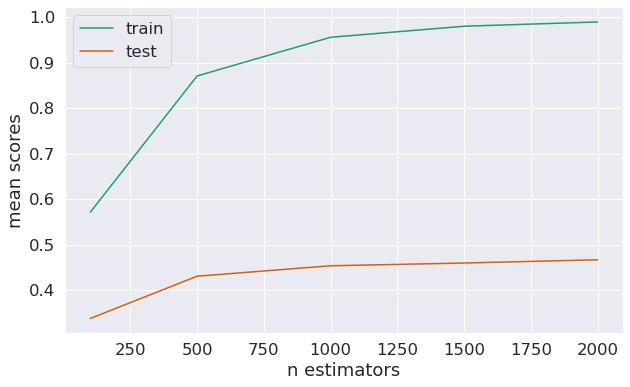

In [8]:
params = pd.DataFrame(model.cv_results_)
fig,ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=params,
             x="param_gbm__n_estimators",
             y="mean_train_score")
sns.lineplot(data=params,
             x="param_gbm__n_estimators",
             y="mean_test_score")
ax.set(xlabel="n estimators",ylabel="mean scores")
plt.legend(labels=['train','test'])
plt.show()

In [9]:
# extrain features and outputs. Store them in X and y
X = energy.drop(columns=['date','Appliances'])
y = energy['Appliances']
# training examples x features
m,n = X.shape
# split test set
Xtrain, Xtest, ytrain,ytest = model_selection.train_test_split(X,y)
# parameters to pass to gridsearchcv
parameters = {'gbm__max_features':range(1,n,2)}
# build pipeline with feature scaling and Ridge linear regression
pipe = pipeline.Pipeline([
                          ('std',preprocessing.StandardScaler()),
                          ('gbm',ensemble.GradientBoostingRegressor())
])
model = model_selection.GridSearchCV(pipe,
                                     parameters,
                                     refit=True,
                                     return_train_score=True,
                                     n_jobs=-1)
model.fit(Xtrain,ytrain)
# prediction training set and test set 
ptrain = model.predict(Xtrain)
ptest = model.predict(Xtest)

err_train = metrics.mean_squared_error(ytrain,ptrain)
print("-> RMSE of training set = %g with score = %g"%(err_train**0.5,model.score(Xtrain,ytrain)))

err_test = metrics.mean_squared_error(ytest,ptest)
print("-> RMSE = %g of test set with score = %g"%(err_test**0.5,model.score(Xtest,ytest)))

print('best parameters from cross validsation: ',model.best_params_)
print('best score from cross validation: ',model.best_score_)

-> RMSE of training set = 81.1194 with score = 0.366351
-> RMSE = 85.4797 of test set with score = 0.328874
best parameters from cross validsation:  {'gbm__max_features': 17}
best score from cross validation:  0.29378771577516716


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_gbm__max_features', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])


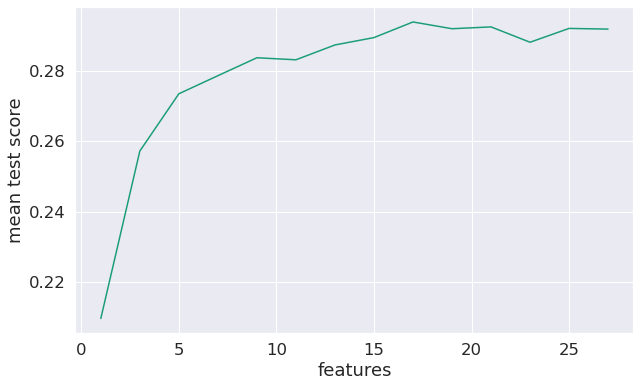

In [10]:
nf = range(1,n,2)
params = model.cv_results_
print(params.keys())
fig,ax = plt.subplots(figsize=(10,6))
sns.lineplot(x=nf,y=params['mean_test_score'])
ax.set(xlabel="features",ylabel="mean test score")
plt.show()

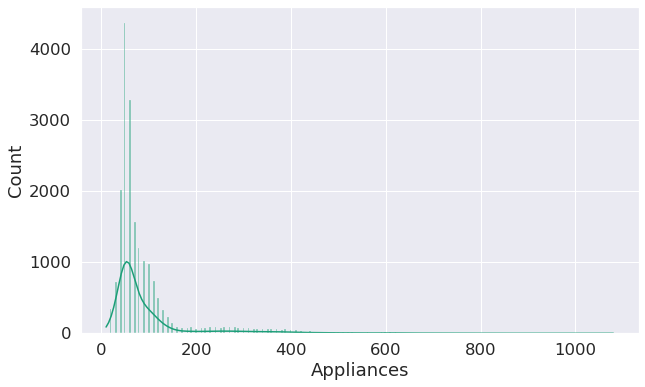

In [19]:
fig,ax = plt.subplots(figsize=(10,6))
sns.histplot(data=energy,x="Appliances",kde=True)
plt.show()

In [15]:
# extrain features and outputs. Store them in X and y
X = energy.drop(columns=['date','Appliances'])
y = energy['Appliances']
# training examples x features
m,n = X.shape
# split test set
Xtrain, Xtest, ytrain,ytest = model_selection.train_test_split(X,y)
# parameters to pass to gridsearchcv
parameters = {'gbm__max_features':[17],
              'gbm__n_estimators':[3000]}
# build pipeline with feature scaling and Ridge linear regression
pipe = pipeline.Pipeline([
                          ('std',preprocessing.StandardScaler()),
                          ('gbm',ensemble.GradientBoostingRegressor())
])
model = model_selection.GridSearchCV(pipe,
                                     parameters,
                                     refit=True,
                                     return_train_score=True,
                                     n_jobs=-1)
model.fit(Xtrain,ytrain)
# prediction training set and test set 
ptrain = model.predict(Xtrain)
ptest = model.predict(Xtest)

err_train = metrics.mean_squared_error(ytrain,ptrain)
print("-> RMSE of training set = %g with score = %g"%(err_train**0.5,model.score(Xtrain,ytrain)))

err_test = metrics.mean_squared_error(ytest,ptest)
print("-> RMSE = %g of test set with score = %g"%(err_test**0.5,model.score(Xtest,ytest)))

print('best parameters from cross validsation: ',model.best_params_)
print('best score from cross validation: ',model.best_score_)

-> RMSE of training set = 32.5891 with score = 0.899655
-> RMSE = 70.379 of test set with score = 0.518701
best parameters from cross validsation:  {'gbm__max_features': 17, 'gbm__n_estimators': 3000}
best score from cross validation:  0.4761945354727516
